In [16]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings("ignore")

# Load data
clean_data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\mixed_filtered.csv", delimiter=",")
# Train-test split: torrwash samples as test set
train_data = clean_data[clean_data['fuel_type'] != 'digestate_pe']
test_data = clean_data[clean_data['fuel_type'] == 'digestate_pe']
print(pd.unique(train_data['fuel_type']))
# Extract features and target
X_train = train_data.drop(columns=['Unnamed: 0','sample', 'fuel_type', 'devol_yield', 'fuel_category'])
y_train = train_data['devol_yield']
X_test = test_data.drop(columns=['Unnamed: 0','sample', 'fuel_type', 'devol_yield', 'fuel_category'])
y_test = test_data['devol_yield']

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define base Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Randomized Search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Fit model
random_search.fit(X_train_scaled, y_train)

# Best model
best_gbr = random_search.best_estimator_
print("\nBest Parameters Found:", random_search.best_params_)

# Evaluate on torrwash test set
y_pred = best_gbr.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nEvaluation on Torr Washed Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Generalization check
cv_best_r2 = random_search.best_score_
test_r2 = r2_score(y_test, y_pred)

print(f"\nGeneralization Check:")
print(f"Cross-Validated R² (Train CV): {cv_best_r2:.4f}")
print(f"Test R² (on unseen test set): {test_r2:.4f}")

gap = cv_best_r2 - test_r2
if gap > 0.1:
    print(f"⚠️ Warning: R² dropped by {gap:.4f} from CV to test — possible overfitting.")
elif gap < -0.05:
    print(f"ℹ️ Test R² is actually higher than CV R² — your model generalizes well!")
else:
    print("✅ No significant generalization gap detected.")

# Save model and scaler
joblib.dump(best_gbr, r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\best_gbr_model_plastic_test.pkl")
joblib.dump(scaler, r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\scaler_plastic.pkl")

print("\nModel and preprocessing pipeline saved.")


['digestate_car' 'digestate_pp']
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters Found: {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 3, 'learning_rate': 0.1}

Evaluation on Torr Washed Test Set:
R² Score: 0.7402
RMSE: 11.2349
MAE: 8.3151

Generalization Check:
Cross-Validated R² (Train CV): 0.5315
Test R² (on unseen test set): 0.7402
ℹ️ Test R² is actually higher than CV R² — your model generalizes well!

Model and preprocessing pipeline saved.


Text(0, 0.5, 'Predicted devol_yield')

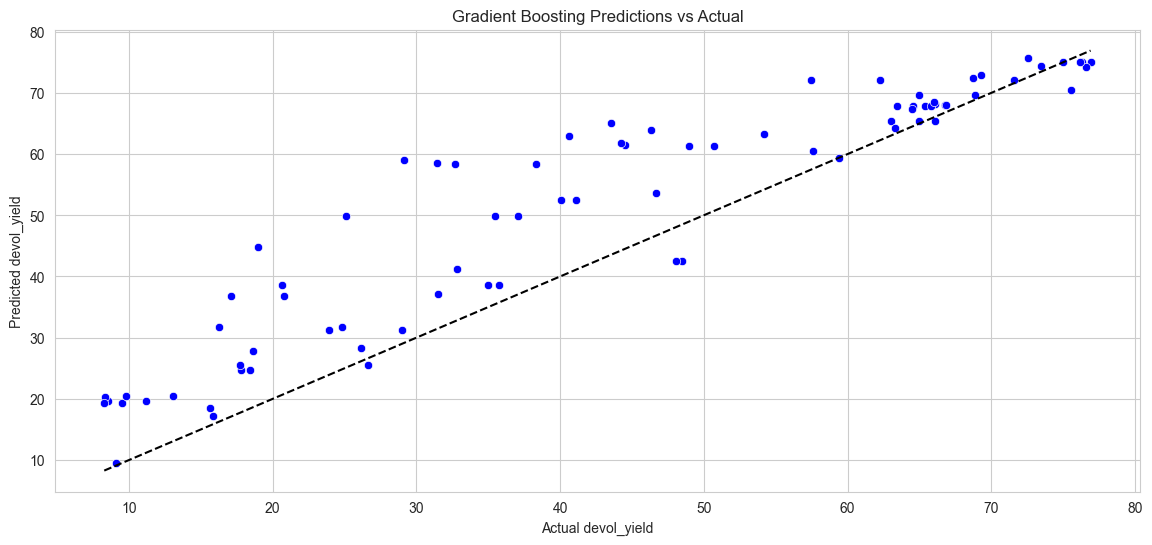

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("Gradient Boosting Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")

(array([ 4., 14., 20.,  8., 12.,  6.,  5.,  4.,  3.,  2.]),
 array([-5.88623651, -2.31619761,  1.2538413 ,  4.8238802 ,  8.39391911,
        11.96395801, 15.53399691, 19.10403582, 22.67407472, 26.24411363,
        29.81415253]),
 <BarContainer object of 10 artists>)

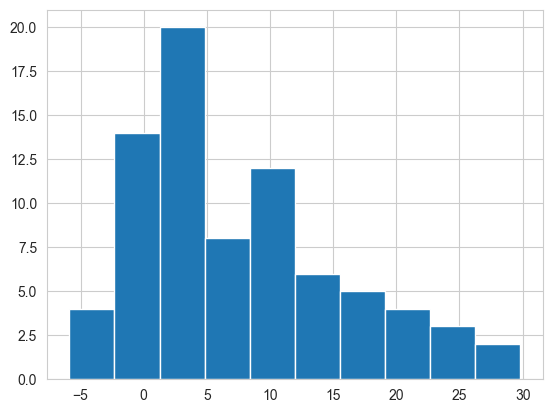

In [18]:
plt.hist(y_pred-y_test)

In [19]:
pd.unique(clean_data['fuel_type'])

array(['digestate_car', 'digestate_pe', 'digestate_pp'], dtype=object)